In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.patches as patches
import numpy as np
import scipy
from scipy.optimize import curve_fit
import cv2
from PIL import Image
import glob

import images_library

##DEFINISCO LA ROI 

La ROI selezionata (determinata da centro dell'immagine della fibra e dal raggio) dipendono dal set di dati utilizzato. 

Per le misure con filtro a 457 nm uso i file: 
guardando le immagini ho stimato che la posizione del centro (X, Y) della fibra nei tre casi è: 
    Misure con PMMA spostato -> "20221102_Flash/2022_11_04_flash_1mm/cerenkov/cerenkov_457_1.TIF" 
    Misure con PMMA centrato -> "20221102_Flash/2022_11_04_flash_1mm/spettro/f8/e9MeV_12Gy_457nm_1.TIF" 

Guardando le immagini ho stimato che la posizione del centro (X, Y) della fibra nei tre casi è: 
    Misure con PMMA spostato -> 322, 236
    Misure con PMMA centrato -> 323, 235



Per le misure senza filtro uso i file:
    Misure con PMMA spostato -> "20221102_Flash/2022_11_04_flash_1mm/cerenkov/cerenkov_open_1.TIF" 
    Misure con PMMA centrato -> "20221102_Flash/2022_11_04_flash_1mm/spettro/f8/e9MeV_12Gy_open_1.TIF"
    Misure senza scintillatore -> "20221102_Flash/2022_11_04_flash_1mm/cerenkov_fibra/fibra_12Gy_1.TIF"
    Misure senza scintillatore e senza PMMA -> "20221102_Flash/2022_11_04_flash_1mm/cerenkov_fibra/fibra_noPMMA_12Gy_1.TIF"


Guardando le immagini ho stimato che la posizione del centro (X, Y) della fibra nei tre casi è: 
    Misure con PMMA spostato -> 322, 235
    Misure con PMMA centrato -> 322, 236
    Misure senza scintillatore -> 260, 225
    Misure senza scintillatore e senza PMMA -> 260, 225
    

7790
File: /home/eleonora/FLASH-Scintillators/20221102_Flash/2022_11_04_flash_1mm/sat/f11/e9MeV_23Gy_1p_4us_3.TIF
Center: 253, 230


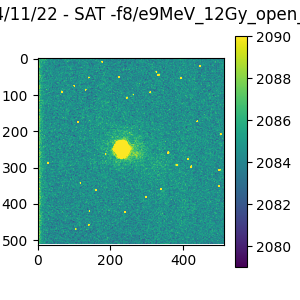

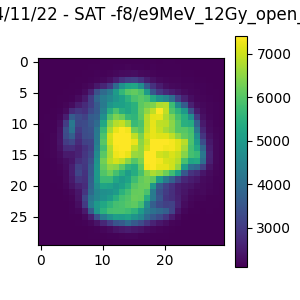

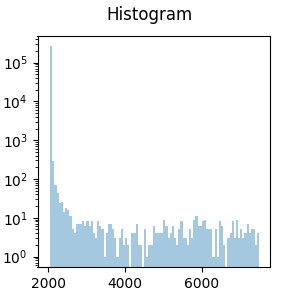

In [60]:
inputFile = "/home/eleonora/FLASH-Scintillators/20221102_Flash/2022_11_04_flash_1mm/sat/f11/e9MeV_23Gy_1p_4us_3.TIF"
imArray=images_library.openImage(inputFile)#bounds=[2000, 3600]
images_library.plotImage(imArray, title="04/11/22 - SAT -f8/e9MeV_12Gy_open_1")#, bounds=[2000, 65000])

print(imArray.max())


images_library.checkSaturation(imArray, saturation=2**16-10)

cenX, cenY= 253, 230#vanno definiti in funzione della posizione della fibra scintillante
r = 15#va impostato

x, y = np.ogrid [:len(imArray[0]) , :len(imArray[1])]
ROI=images_library.defineROI(x, y, cenX, cenY, r)
images_library.plotImage(images_library.applySquareROI(imArray, cenX, cenY, r), title="04/11/22 - SAT -f8/e9MeV_12Gy_open_1")

vmin, vmax= 2000, 7500
bins=np.linspace(vmin-0.5, vmax+0.5, 100 )
images_library.histImage(imArray, bins=bins, title ="Histogram")

print("File: %s" % inputFile )
print("Center: %d, %d" % (cenX, cenY))

###Buio
Seleziono i file di buio nelle rispettive cartelle per poter fare la sottrazione con i dati
Con e senza filtro:
    Misure con PMMA spostato -> "20221102_Flash/2022_11_04_flash_1mm/cerenkov/*buio*.TIF" -> word = "buio_1"/"buio_457"
    Misure con PMMA centrato -> "20221102_Flash/2022_11_04_flash_1mm/spettro/f8/*buio*.TIF" -> word = "buio_open"/"buio_457"
Solo senza filtro:
    Misure senza scintillatore e/o senza PMMA -> "20221102_Flash/2022_11_04_flash_1mm/cerenkov_fibra/*buio*.TIF" - "buio_1"/"buio_noPMMA_1" (qui in realtà abbiamo fatto tante misure di buio ma io ne seleziono una delle tante)


In [ ]:
darkFiles = glob.glob(f"20221102_Flash/2022_11_04_flash_1mm/spettro/f8/*buio*.TIF")

darkDict={}
word = "buio_open"
keyDark=images_library.fillDict(darkDict, darkFiles, word, "dati")
for k in keyDark:
    images_library.plotImage(images_library.applySquareROI(darkDict[k], cenX, cenY, r), title='%s in the ROI' %k)
    images_library.plotImage(darkDict[k], title ='%s' %k)

###DATI
Seleziono i file di dati nelle rispettive cartelle per poter fare la sottrazione con i dati
Con e senza filtro:
    Misure con PMMA spostato -> "20221102_Flash/2022_11_04_flash_1mm/cerenkov/cerenkov*.TIF" , word = "open"/"457"
    Misure con PMMA centrato -> "20221102_Flash/2022_11_04_flash_1mm/spettro/f8/*.TIF" -> word = "open"/"457" (?)
Solo senza filtro:
    Misure senza scintillatore -> "20221102_Flash/2022_11_04_flash_1mm/cerenkov_fibra/*.TIF" -> word = "fibra_12Gy"
    Misure senza scintillatore e senza PMMA -> "20221102_Flash/2022_11_04_flash_1mm/cerenkov_fibra/*.TIF"  -> word = "fibra_noPMMA_12Gy"

In [ ]:
cerenkovFiles = glob.glob(f"20221102_Flash/2022_11_04_flash_1mm/spettro/f8/*.TIF" )
cerDictFiles={}
word = "open"
keys=images_library.fillDict(cerDictFiles, cerenkovFiles, word, "buio")

In [ ]:
cerDiff = images_library.diffImDark(cerDictFiles, darkDict[keyDark[0]])
lightIntegral=[]
nOfPixels=[]
for im in cerDiff: 
    eventROI = images_library.applySquareROI(im, cenX, cenY, r)
    images_library.plotImage(eventROI)    
    vmin, vmax= 0, 2500
    bins=np.linspace(vmin-0.5, vmax+0.5, 100 )
    images_library.histImage(eventROI, bins=bins)
    lightIntegral.append(np.sum(im[ROI]))    
    nOfPixels.append(len(im[ROI]))
    
print("N of pixels with more events than background: ", nOfPixels)
print("Light integral in the ROI: ", lightIntegral)
mean = np.array(lightIntegral)/np.array(nOfPixels)
print("Mean light in the ROI: ", mean)

lightMean = np.mean(mean)
lightStdev = np.std(mean)



In [ ]:
print('Mean: %d, Stdev: %d' % (lightMean, lightStdev))


In [ ]:
#Guardo le variazioni del risultato in funzione della dimensione della ROI
ROIs = []
lightIntegralStdev = []
lightIntegralMean=[]
radii = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

for r in radii:
    roi=images_library.defineROI(x, y, cenX, cenY, r)
    ROIs.append(roi)
    l = []
    for im in cerDiff: 
        eventROI = images_library.applySquareROI(im, cenX, cenY, r)
        l.append(np.sum(im[roi]))
    lightIntegralMean.append(np.mean(l))
    lightIntegralStdev.append(np.std(l))
    
print(radii)    
print(np.array(lightIntegralMean, dtype=np.int32))
print(np.array(lightIntegralStdev, dtype=np.int32))

fig, ax = plt.subplots(1,1)
ax.errorbar(radii, lightIntegralMean, yerr=lightIntegralStdev, fmt='.')
ax.set_xlabel("Raggio ROI [n of pixel]")
ax.set_ylabel("Integrale segnale")


In [ ]:
#y1 = Moved
#y2 = Moved, 457 nm
#y3 = Centered 
#y4 = Centered, 457 nm
#y5 = no scint 
#y6 = no scint no PMMA


x= [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
y1 = [ 97681, 150579, 193260, 243311, 294143, 339488, 384942, 409853, 417666, 419858, 420868]
dy1=[ 112,  314,  305,  380,  619,  721,  975, 1190, 1192, 1245, 1255]

y2=[ 4811,  7185,  9056, 11164, 13272, 15148, 17005, 18192, 18729, 18768, 18758]
dy2=[29, 53, 55, 38, 66, 72, 38, 69, 73, 66, 47]

y3=[ 4046923,  6191056,  7894737,  9803327, 11623611, 13212817, 14740792, 15536065,
             15826651, 15896961, 15926872]
dy3=[ 9908, 17292, 23894, 31263, 39585, 48562, 57265, 60999, 62302, 62702, 62826]
y4=[ 793639, 1190898, 1493991, 1835731, 2154724, 2423627, 2685431, 2827163, 2869214,2879750, 2884716]
dy4=[1980, 2927, 3742, 4305, 5299, 5563, 6248, 6337, 6376, 6402, 6387]

y5=[ 307085, 469681,  609081,  785514,  975837, 1142848, 1302896, 1383962, 1422628,
 1432533, 1436431]
dy5=[  43,  367,  818,  981, 1152, 1254, 1630, 1551, 1416, 1432, 1449]

y6=[ 236247,  361088, 468436,  604548,  751455,  880810, 1004863, 1067614, 1097449, 1105019, 1107933]
dy6=[1244, 1675, 1963, 2302, 2524, 2743, 3229, 3491, 3669, 3712, 3772]

In [ ]:
fig, ax = plt.subplots(1,1)
ax.errorbar(x, y1, yerr=dy1, fmt='.', label="PMMA moved") 
ax.errorbar(x, y3, yerr=dy3, fmt='.', label="PMMA centered")
ax.errorbar(x, y5, yerr=dy5, fmt='.', label="w/o scintillator")
ax.errorbar(x, y6, yerr=dy6, fmt='.', label="w/o scintillator, w/o PMMA")

ax.set_xlabel("ROI radius [n of pixel]")
ax.set_ylabel("Signal")
fig.legend(loc="center right")

In [ ]:
def ratioError(a,b, aErr, bErr):
    a = np.array(a)
    b=np.array(b)
    aErr = np.array(aErr)
    bErr=np.array(bErr)  
    error =np.sqrt((aErr/b)**2 + (bErr/b * a/b)**2) 
    return error

def ratio(a,b):
    a=np.array(a)
    b=np.array(b)
    return a/b


def plot(x, y, yerr, label='', fmt='.'):
    fig, ax = plt.subplots(1,1, figsize=(8,6))
    ax.errorbar(x, ratio(y,y3), yerr=ratioError(y, y3, yerr, dy3), fmt=fmt, label=label)
    ax.set_ylabel("Signal/Centered", fontsize=16)
    ax.set_xlabel("Raggio ROI [n of pixel]", fontsize=16)
    fig.legend(loc="upper center", fontsize=20)
  

plot(x, y1, dy1, "Moved/Centered")
plot(x, y5, dy5, "w/o scintillator/Centered", fmt=".g")
plot(x, y6, dy6, "w/o scintillator & PMMA/Centered", fmt='.r')



print("ratio y1 and y3: %f +- %f" % (np.mean(ratio(y1,y3))*100, np.std(ratio(y1,y3))*100) )
print("ratio y5 and y3: %f +- %f" %(np.mean(ratio(y5,y3))*100, np.std(ratio(y5,y3))*100) ) 
print("ratio y6 and y3: %f +- %f" %(np.mean(ratio(y6,y3))*100, np.std(ratio(y6,y3))*100) ) 
                         
print("y1: min, max %f %f" %(ratio(y1,y3).min() * 100, ratio(y1,y3).max() * 100))
print("y5: min, max %f %f" %(ratio(y5,y3).min() * 100, ratio(y5,y3).max() * 100))
print("y6: min, max %f %f" %(ratio(y6,y3).min() * 100, ratio(y6,y3).max() * 100))

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.errorbar(x, y2, yerr=dy2, fmt=".", label="Moved")
ax.errorbar(x, y4, yerr=dy4, fmt=".", label="Centered")
ax.set_ylabel("Signal", fontsize=16)
ax.set_xlabel("Raggio ROI [n of pixel]", fontsize=16)
fig.legend(loc="upper center", fontsize=20)


fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.errorbar(x, ratio(y2,y4), yerr=ratioError(y2, y4, dy2, dy4), fmt=".", label="Moved/Centered @ 457 nm")
ax.set_ylabel("Moved/Centered", fontsize=16)
ax.set_xlabel("Raggio ROI [n of pixel]", fontsize=16)
fig.legend(loc="upper center", fontsize=20)

print("ratio y2 and y4: %f +- %f" % (np.mean(ratio(y2,y4))*100, np.std(ratio(y2,y4))*100) )
